# <a id="table-of-contents"></a>Table of Contents

1. [Intraday Mean Reversion](#section1)
2. [Moving Average](#section2)
3. [OBV](#section3)


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import numpy as np
import warnings
import seaborn as sns


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.integrate import simps
from scipy.interpolate import interp1d
from scipy.integrate import quad


In [2]:
# Define the path to the Downloads folder and the file
downloads_folder = os.path.expanduser("~/Desktop")
file_name = "aaHistoricalData_1726248252859.csv" 
file_path = os.path.join(downloads_folder, file_name)

# Read the CSV file into a DataFrame
data = pd.read_csv(file_path)

In [3]:
# Convert 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Sort the DataFrame by date in ascending order
data = data.sort_values(by='Date', ascending=True)

print(data.head(3))

           Date  Close/Last     Volume    Open    High     Low
2515 2014-09-15     198.981   76350030  199.16  199.32  198.38
2514 2014-09-16     200.480  116039000  198.61  200.84  198.50
2513 2014-09-17     200.750  149647200  200.77  201.68  199.75


In [4]:
# Assuming 'data' is your existing DataFrame
data['Original_Index'] = data.index  # Add the Original_Index column to capture current index
print('''It will record the INDEX to make sure that future data manipulations don't force us to lose the order.''')

It will record the INDEX to make sure that future data manipulations don't force us to lose the order.


In [5]:
# Add new columns with the given calculations
data['High_minus_Open'] = (data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)
data['Open_minus_Low'] = (data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2)
data['day_change'] = (data['Close/Last'] - data['Close/Last'].shift(1)) / data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']

In [6]:
# Add new columns with the given calculations
data['Prev_Close'] = data['Close/Last'].shift(1)
data['opening_gaps'] = (data['Open'] - data['Close/Last'].shift(1)) / ((data['Open'] + data['Close/Last']) / 2)
data['net_Intraday_Movement_Around_Open_Ratio'] = ((data['High'] - data['Open']) / ((data['Open'] + data['Close/Last']) / 2)) - ((data['Open'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))
data['Intraday_Volatility'] = ((data['High'] - data['Low']) / ((data['Open'] + data['Close/Last']) / 2))

In [7]:
# Calculate day change adjusted for opening gap
data['day_change_adjusted_for_openning_gap'] = data['day_change'] - data['opening_gaps']


# Create moving average columns
data['MA_5'] = data['Open'].rolling(window=5).mean()
data['MA_14'] = data['Open'].rolling(window=14).mean()
data['MA_50'] = data['Open'].rolling(window=50).mean()


# Create features comparing today's open to these moving averages
data['open_above_MA_5'] = (data['Open'] > data['MA_5']).astype(int)
data['open_above_MA_14'] = (data['Open'] > data['MA_14']).astype(int)
data['open_above_MA_50'] = (data['Open'] > data['MA_50']).astype(int)

# Create a crossover signal column
data['MA_Crossover_Signal_5_14'] = ((data['MA_5'] > data['MA_14']) & (data['MA_5'].shift(1) <= data['MA_5'].shift(1))).astype(int)
data['MA_Crossover_Signal_today_5'] = ((data['Close/Last'] > data['MA_14']) & (data['Close/Last'].shift(1) <= data['MA_5'].shift(1))).astype(int)


# Shift 'High' and 'Low' columns by 1
data['High_shift'] = data['High'].shift(1)
data['Low_shift'] = data['Low'].shift(1)

# Define the opening gap with the condition
def calculate_opening_gaps(row):
    if row['Open'] > row['High_shift']:
        return (row['Open'] - row['High_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    elif row['Open'] < row['Low_shift']:
        return (row['Open'] - row['Low_shift']) / ((row['Open'] + row['Close/Last']) / 2)
    else:
        return np.nan

# Apply the calculation function to each row
data['opening_gaps_2'] = data.apply(calculate_opening_gaps, axis=1)

data.dropna(inplace=True)

END OF SETUP

# <a id="section4"></a> Opening Gaps and Intraday Volatility
[Back to Table of Contents](#table-of-contents)


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.083
Model:                             OLS   Adj. R-squared:                  0.077
Method:                  Least Squares   F-statistic:                     12.58
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):           0.000513
Time:                         09:19:26   Log-Likelihood:                 569.85
No. Observations:                  161   AIC:                            -1136.
Df Residuals:                      159   BIC:                            -1130.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0057      0.002    

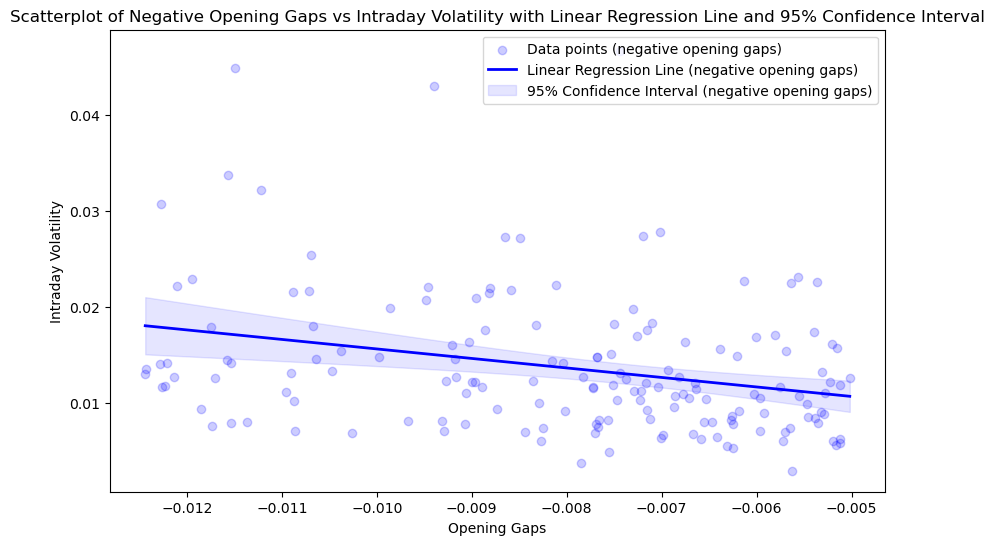

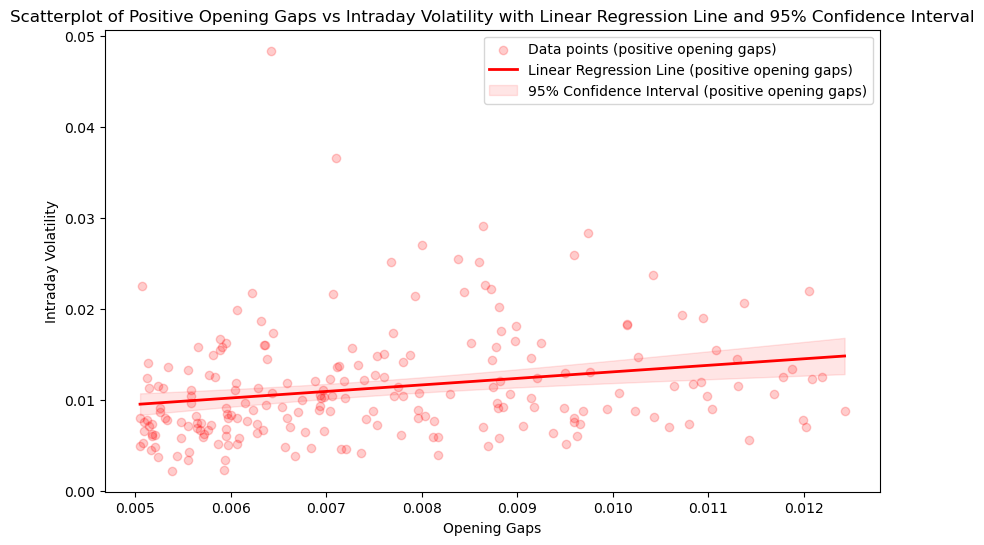

Negative Opening Gaps - Lagrange multiplier statistic: 3.0783753045505655
Negative Opening Gaps - p-value: 0.07933974461451698
Positive Opening Gaps - Lagrange multiplier statistic: 0.0445495438705501
Positive Opening Gaps - p-value: 0.8328344997663795

Addres the heteroskedasticity at least in part by doing a log trnasformation



In [12]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.0125) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.0125) & (data['Intraday_Volatility'] <= 0.05)].copy()

# First regression (below -0.005 and greater than -0.02)
X_below = filtered_data_below['opening_gaps']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['opening_gaps'])
sorted_opening_gaps_below = filtered_data_below['opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Second regression (greater than 0.005 and less than 0.02)
X_above = filtered_data_above['opening_gaps']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['opening_gaps'])
sorted_opening_gaps_above = filtered_data_above['opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (negative opening gaps)')

# Plot the linear regression line for the first regression
plt.plot(sorted_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Linear Regression Line (negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (negative opening gaps)')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Negative Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (positive opening gaps)')

# Plot the linear regression line for the second regression
plt.plot(sorted_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Linear Regression Line (positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (positive opening gaps)')

# Add labels and title
plt.xlabel('Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Positive Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Addres the heteroskedasticity at least in part by doing a log trnasformation
''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.084
Model:                             OLS   Adj. R-squared:                  0.078
Method:                  Least Squares   F-statistic:                     13.74
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):           0.000290
Time:                         09:20:27   Log-Likelihood:                 569.95
No. Observations:                  161   AIC:                            -1136.
Df Residuals:                      159   BIC:                            -1130.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 

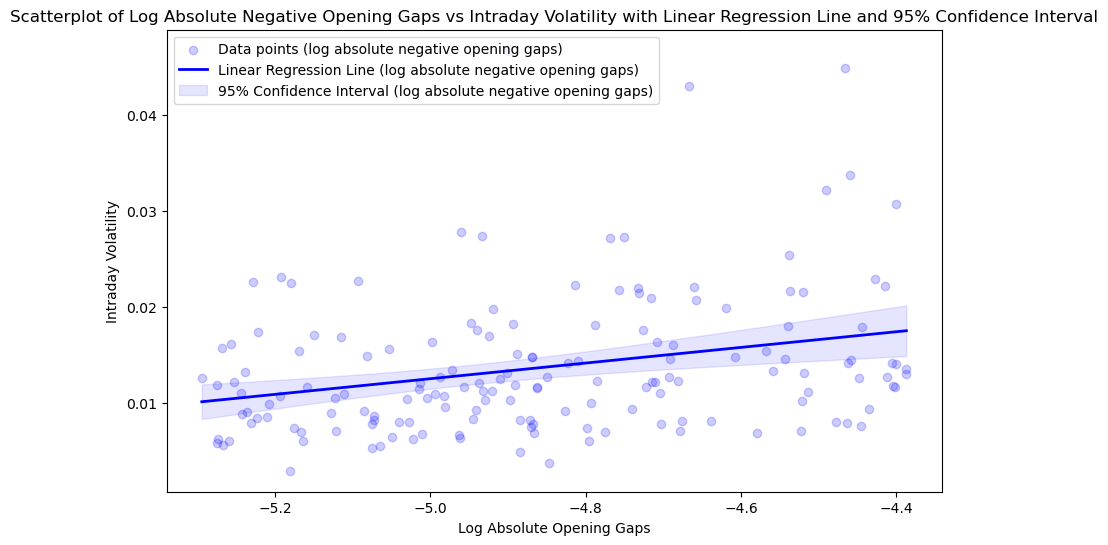

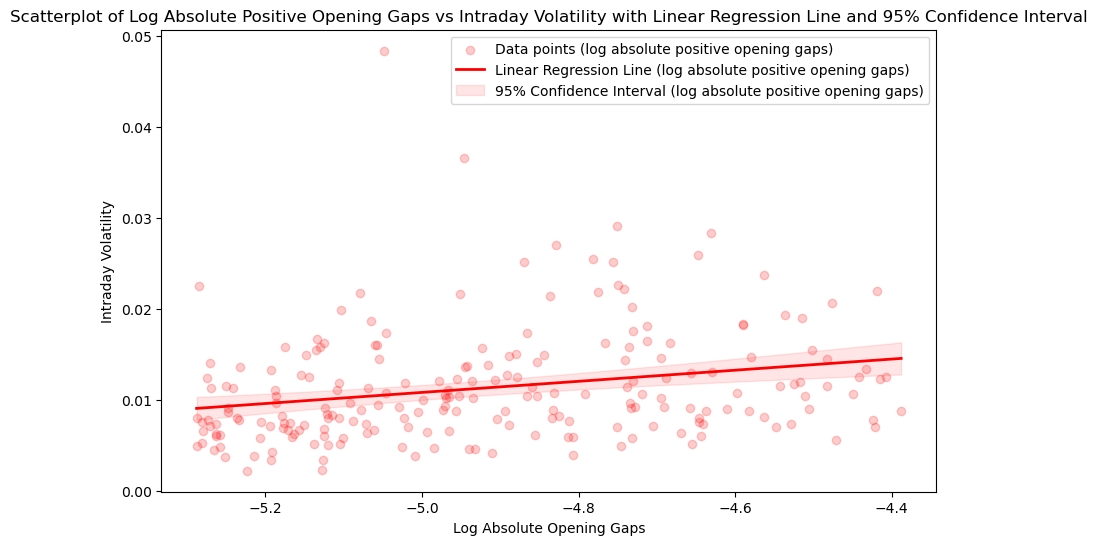

Negative Opening Gaps - Lagrange multiplier statistic: 3.153070838079643
Negative Opening Gaps - p-value: 0.07578421869129202
Positive Opening Gaps - Lagrange multiplier statistic: 0.15098608105412803
Positive Opening Gaps - p-value: 0.6975947994642718
 

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

redcing the gap range to .5% to 1% fixes the heteroskedasticty issue.




In [13]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.0125) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.0125) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# First regression (below -0.005 and greater than -0.02)
X_below = filtered_data_below['log_abs_opening_gaps']
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Second regression (greater than 0.005 and less than 0.02)
X_above = filtered_data_above['log_abs_opening_gaps']
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the linear regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Linear Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the linear regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Linear Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps vs Intraday Volatility with Linear Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print(''' 

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

redcing the gap range to .5% to 1% fixes the heteroskedasticty issue.

''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.088
Model:                             OLS   Adj. R-squared:                  0.078
Method:                  Least Squares   F-statistic:                     9.027
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):           0.000186
Time:                         09:18:34   Log-Likelihood:                 626.94
No. Observations:                  178   AIC:                            -1248.
Df Residuals:                      175   BIC:                            -1238.
Df Model:                            2                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

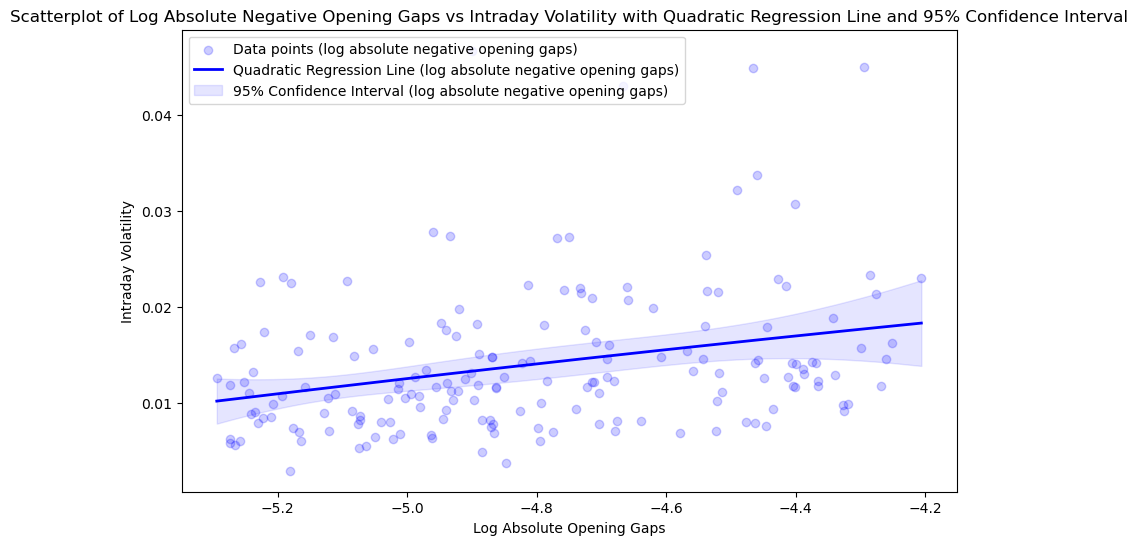

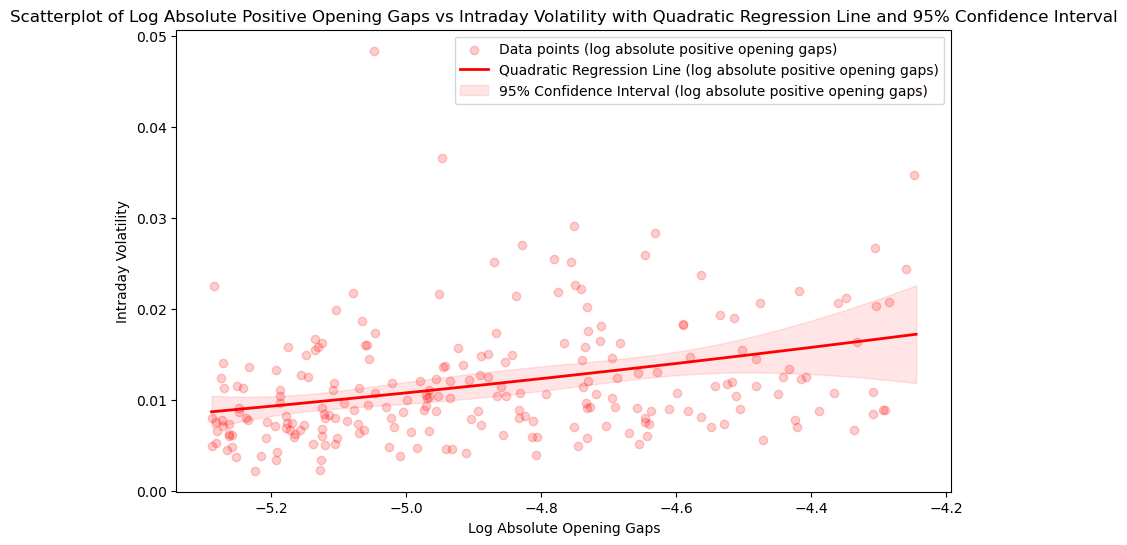

Negative Opening Gaps - Lagrange multiplier statistic: 3.1442897783302355
Negative Opening Gaps - p-value: 0.20759942671864087
Positive Opening Gaps - Lagrange multiplier statistic: 3.338005014977825
Positive Opening Gaps - p-value: 0.18843493436019965

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.



In [10]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.015) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.015) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# Add quadratic term for the first regression
filtered_data_below['log_abs_opening_gaps_squared'] = filtered_data_below['log_abs_opening_gaps'] ** 2

X_below = filtered_data_below[['log_abs_opening_gaps', 'log_abs_opening_gaps_squared']]
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Add quadratic term for the second regression
filtered_data_above['log_abs_opening_gaps_squared'] = filtered_data_above['log_abs_opening_gaps'] ** 2

X_above = filtered_data_above[['log_abs_opening_gaps', 'log_abs_opening_gaps_squared']]
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the quadratic regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Quadratic Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the quadratic regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Quadratic Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.
''')


                             OLS Regression Results                            
Dep. Variable:     Intraday_Volatility   R-squared:                       0.088
Model:                             OLS   Adj. R-squared:                  0.083
Method:                  Least Squares   F-statistic:                     16.95
Date:                 Sun, 17 Nov 2024   Prob (F-statistic):           5.89e-05
Time:                         09:18:34   Log-Likelihood:                 626.94
No. Observations:                  178   AIC:                            -1250.
Df Residuals:                      176   BIC:                            -1244.
Df Model:                            1                                         
Covariance Type:                   HC3                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

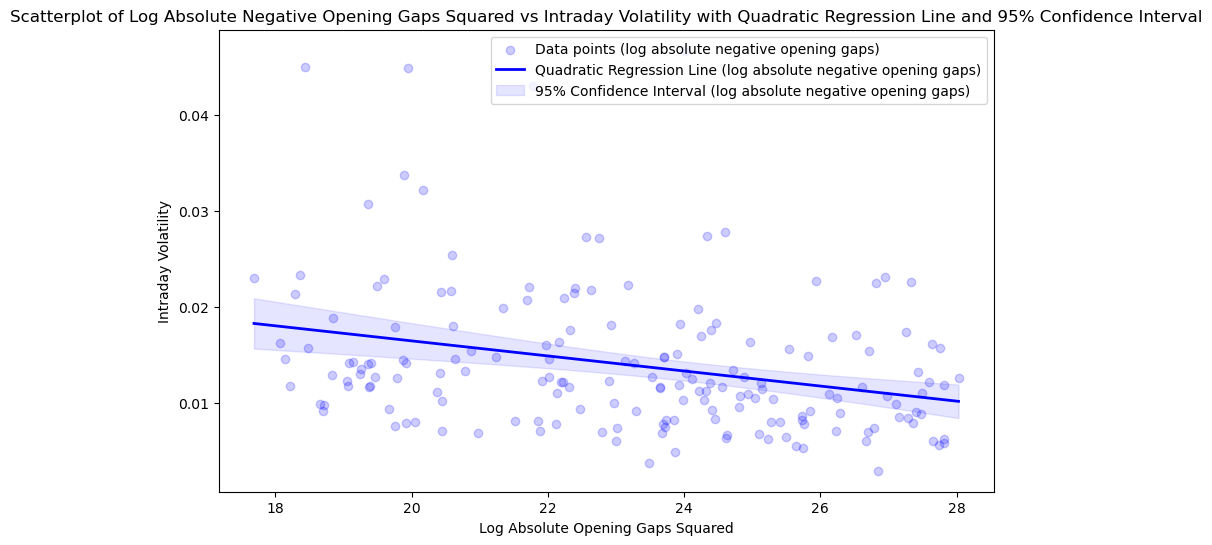

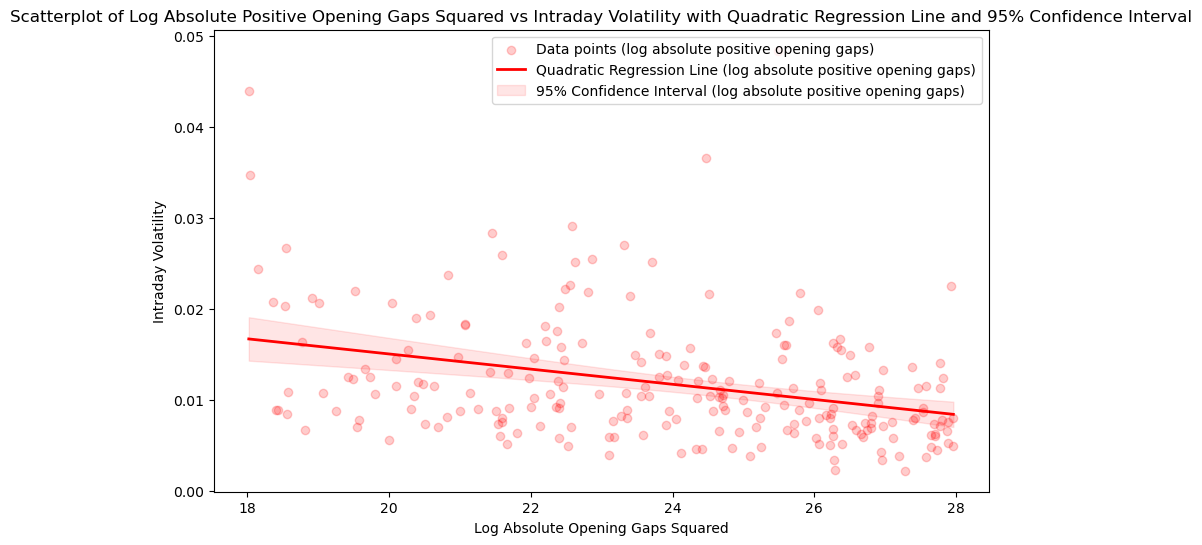

Negative Opening Gaps - Lagrange multiplier statistic: 3.0323194599512284
Negative Opening Gaps - p-value: 0.08162125907706294
Positive Opening Gaps - Lagrange multiplier statistic: 2.988357861492549
Positive Opening Gaps - p-value: 0.08386517496938171

Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.



In [11]:
# Filter the DataFrame based on the specified criteria and intraday volatility
filtered_data_below = data.loc[(data['opening_gaps'] > -0.015) & (data['opening_gaps'] < -0.005) & (data['Intraday_Volatility'] <= 0.05)].copy()
filtered_data_above = data.loc[(data['opening_gaps'] > 0.005) & (data['opening_gaps'] < 0.015) & (data['Intraday_Volatility'] <= 0.05)].copy()

# Apply log transformation using the absolute values
filtered_data_below['log_abs_opening_gaps'] = np.log(np.abs(filtered_data_below['opening_gaps']))
filtered_data_above['log_abs_opening_gaps'] = np.log(filtered_data_above['opening_gaps'])

# Add quadratic term for the first regression
filtered_data_below['log_abs_opening_gaps_squared'] = filtered_data_below['log_abs_opening_gaps'] ** 2

X_below = filtered_data_below[['log_abs_opening_gaps_squared']]
X_below = sm.add_constant(X_below)  # Adds a constant term to the predictor

y_below = filtered_data_below['Intraday_Volatility']

# Fit the model with RBSE
model_below = sm.OLS(y_below, X_below).fit(cov_type='HC3')

# Print the OLS results
print(model_below.summary())

# Predict values and get confidence intervals
predictions_below = model_below.get_prediction(X_below)
predictions_below_summary = predictions_below.summary_frame(alpha=0.05)
predicted_mean_below = predictions_below_summary['mean']
conf_int_below_lower = predictions_below_summary['mean_ci_lower']
conf_int_below_upper = predictions_below_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_below = np.argsort(filtered_data_below['log_abs_opening_gaps_squared'])
sorted_log_abs_opening_gaps_below = filtered_data_below['log_abs_opening_gaps_squared'].values[sorted_idx_below]
sorted_conf_int_below_lower = conf_int_below_lower.values[sorted_idx_below]
sorted_conf_int_below_upper = conf_int_below_upper.values[sorted_idx_below]
sorted_predicted_mean_below = predicted_mean_below.values[sorted_idx_below]

# Add quadratic term for the second regression
filtered_data_above['log_abs_opening_gaps_squared'] = filtered_data_above['log_abs_opening_gaps'] ** 2

X_above = filtered_data_above[['log_abs_opening_gaps_squared']]
X_above = sm.add_constant(X_above)  # Adds a constant term to the predictor

y_above = filtered_data_above['Intraday_Volatility']

# Fit the model with RBSE
model_above = sm.OLS(y_above, X_above).fit(cov_type='HC3')

# Print the OLS results
print(model_above.summary())

# Predict values and get confidence intervals
predictions_above = model_above.get_prediction(X_above)
predictions_above_summary = predictions_above.summary_frame(alpha=0.05)
predicted_mean_above = predictions_above_summary['mean']
conf_int_above_lower = predictions_above_summary['mean_ci_lower']
conf_int_above_upper = predictions_above_summary['mean_ci_upper']

# Sort the values for fill_between
sorted_idx_above = np.argsort(filtered_data_above['log_abs_opening_gaps_squared'])
sorted_log_abs_opening_gaps_above = filtered_data_above['log_abs_opening_gaps_squared'].values[sorted_idx_above]
sorted_conf_int_above_lower = conf_int_above_lower.values[sorted_idx_above]
sorted_conf_int_above_upper = conf_int_above_upper.values[sorted_idx_above]
sorted_predicted_mean_above = predicted_mean_above.values[sorted_idx_above]

# Create the scatter plot for negative opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the first regression
plt.scatter(filtered_data_below['log_abs_opening_gaps_squared'], filtered_data_below['Intraday_Volatility'], 
                             color='blue', alpha=0.2, label='Data points (log absolute negative opening gaps)')

# Plot the quadratic regression line for the first regression
plt.plot(sorted_log_abs_opening_gaps_below, sorted_predicted_mean_below, color='blue', linewidth=2, label='Quadratic Regression Line (log absolute negative opening gaps)')

# Plot the confidence intervals for the first regression
plt.fill_between(sorted_log_abs_opening_gaps_below, sorted_conf_int_below_lower, sorted_conf_int_below_upper, color='blue', alpha=0.1, label='95% Confidence Interval (log absolute negative opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps Squared')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Negative Opening Gaps Squared vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Create the scatter plot for positive opening gaps
plt.figure(figsize=(10, 6))

# Scatter plot for the second regression
plt.scatter(filtered_data_above['log_abs_opening_gaps_squared'], filtered_data_above['Intraday_Volatility'], 
                             color='red', alpha=0.2, label='Data points (log absolute positive opening gaps)')

# Plot the quadratic regression line for the second regression
plt.plot(sorted_log_abs_opening_gaps_above, sorted_predicted_mean_above, color='red', linewidth=2, label='Quadratic Regression Line (log absolute positive opening gaps)')

# Plot the confidence intervals for the second regression
plt.fill_between(sorted_log_abs_opening_gaps_above, sorted_conf_int_above_lower, sorted_conf_int_above_upper, color='red', alpha=0.1, label='95% Confidence Interval (log absolute positive opening gaps)')

# Add labels and title
plt.xlabel('Log Absolute Opening Gaps Squared')
plt.ylabel('Intraday Volatility')
plt.title('Scatterplot of Log Absolute Positive Opening Gaps Squared vs Intraday Volatility with Quadratic Regression Line and 95% Confidence Interval')

# Add legend
plt.legend()

# Show and save the plot
plt.show()

# Perform the Breusch-Pagan test for the first regression
test_below = sms.het_breuschpagan(model_below.resid, model_below.model.exog)
print(f'Negative Opening Gaps - Lagrange multiplier statistic: {test_below[0]}')
print(f'Negative Opening Gaps - p-value: {test_below[1]}')

# Perform the Breusch-Pagan test for the second regression
test_above = sms.het_breuschpagan(model_above.resid, model_above.model.exog)
print(f'Positive Opening Gaps - Lagrange multiplier statistic: {test_above[0]}')
print(f'Positive Opening Gaps - p-value: {test_above[1]}')

print('''
Yes, the fact that your data is already log-transformed and you're still seeing significant heteroskedasticity in the Breusch-Pagan test results does indicate a 
serious issue. The purpose of log transformation is often to stabilize variance and address heteroskedasticity, so the persistence of heteroskedasticity even after
transformation suggests that the variance in your data is quite problematic.

Reducing the gap range to .5% to 1% fixes the heteroskedasticity issue.
''')
